In [29]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
tf.keras.backend.set_floatx('float64')

%matplotlib inline
np.random.seed(1)

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [3]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


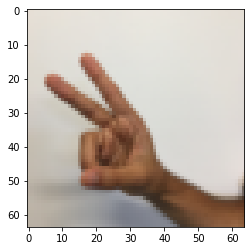

In [4]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [5]:
print(Y_train_orig[:, 6])

[2]


In [6]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [7]:
# FROM Coursera - Check out variable initialization

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Note that we will hard code the shape values in the function to make the grading simpler.
    Normally, functions should take values as inputs rather than hard coding.
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    tf.random.set_seed(1)
    W1 = tf.Variable(tf.initializers.GlorotNormal()(shape=(4, 4, 3, 8), dtype=float))
    W2 = tf.Variable(tf.initializers.GlorotNormal()(shape=(2, 2, 8, 16), dtype=float))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

parameters = initialize_parameters()
print("W1[1,1,1] = \n" + str(parameters["W1"][1,1,1]))
print("W1.shape: " + str(parameters["W1"].shape))
print("\n")
print("W2[1,1,1] = \n" + str(parameters["W2"][1,1,1]))
print("W2.shape: " + str(parameters["W2"].shape))

W1[1,1,1] = 
tf.Tensor(
[-0.12104932 -0.04759157  0.03188677 -0.1167869   0.18127356 -0.05290989
 -0.10912307  0.05110231], shape=(8,), dtype=float32)
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
tf.Tensor(
[-0.12959254  0.07943443 -0.02809872 -0.17788276  0.12636003 -0.10774837
 -0.27257574 -0.06566172 -0.15071881 -0.2715964  -0.08285839  0.03547129
  0.04168037 -0.21161394 -0.02594873  0.18559211], shape=(16,), dtype=float32)
W2.shape: (2, 2, 8, 16)


* Conv2D: stride 1, padding is "SAME"
* ReLU
* Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
* Conv2D: stride 1, padding is "SAME"
* ReLU
* Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
* Flatten the previous output.
* FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost.

In [8]:
model = tf.keras.models.Sequential()
#W1 : [4, 4, 3, 8]
model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=4, strides=(1,1),padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(8, 8), strides=(8,8), padding='same'))
#W2 [2, 2, 8, 16]
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, strides=(1,1),padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=(4,4), padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(6))

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [9]:
print(X_train.shape)
print(Y_train_orig.T.shape)
print(Y_train_orig.T[6])
preds = model(X_train[5:6]).numpy()
print("preds")
print(preds)
print("preds softmax")
print(tf.nn.softmax(preds).numpy())
print("preds loss")
print(loss_fn(Y_train_orig.T[5:6], preds).numpy())

(1080, 64, 64, 3)
(1080, 1)
[2]
preds
[[-0.15616947  0.25084806 -0.05175307  0.29050144 -0.33121447 -0.10268311]]
preds softmax
[[0.14144562 0.21249807 0.15701349 0.22109363 0.11873218 0.14921701]]
preds loss
2.130884885787964


In [10]:
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
allhistory={"accuracy":[], "loss":[]}
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  392       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  390       
Total params: 1,310
Trainable params: 1,310
Non-trainable params: 0
______________________________________________________

In [25]:
history = model.fit(X_train, Y_train_orig.T, epochs=5, verbose=1)
allhistory = {key: value + history.history[key] for key, value in allhistory.items()}

Train on 1080 samples
Epoch 1/5
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.8671 - accuracy: 0.7417
Epoch 2/5
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.8709 - accuracy: 0.7148
Epoch 3/5
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.8181 - accuracy: 0.7519
Epoch 4/5
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.8053 - accuracy: 0.7546
Epoch 5/5
1080/1080 [==============================] - 2s 2ms/sample - loss: 0.7794 - accuracy: 0.7630


dict_keys(['accuracy', 'loss'])
total epoch: 25


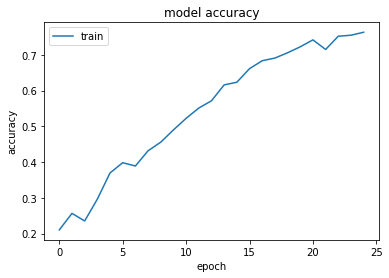

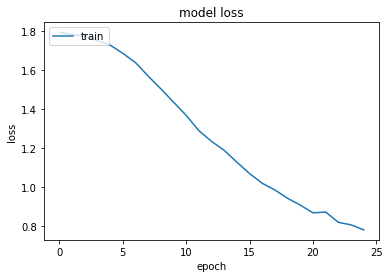

In [26]:
print(allhistory.keys())
print("total epoch: %d"%len(allhistory["accuracy"]))
#  "Accuracy"
plt.plot(allhistory['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(allhistory['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
model.evaluate(X_test,  Y_test_orig.T, verbose=2)
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

120/120 - 0s - loss: 0.8976 - accuracy: 0.6083


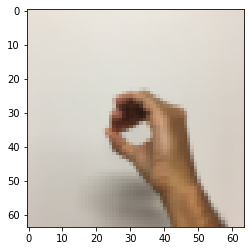

[[1. 0. 0. 0. 0. 0.]]


In [32]:
plt.imshow(X_test[0], cmap='gray')
plt.show()
print(probability_model(X_test[:1]*255).numpy())

(1, 64, 64, 3)
[[0. 0. 0. 1. 0. 0.]]


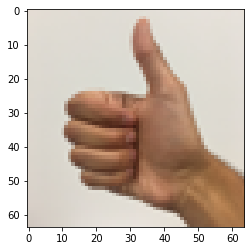

In [33]:
from PIL import Image

fname = "thumbs_up.jpg"
image = np.array(Image.open(fname).resize((64,64)))[np.newaxis, ...]
print(image.shape)
plt.imshow(image[0])
print(probability_model(image*255.0).numpy())

# Incorrect output for thumbs up because 
![signs](signs.PNG)

# Plotting models + Toy Resnet

# Option 1

from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot

tf.keras.utils.plot_model(model)

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Option 1
import keras, IPython

keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)

IPython.display.Image("test_keras_plot_model.png")

# Option 2

IPython.display.SVG(keras.utils.vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

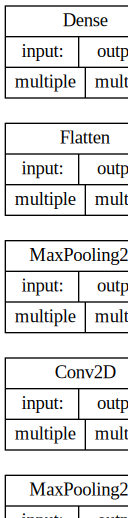

In [34]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_keras_model(model, show_shapes=True,show_layer_names=True):
    return SVG(model_to_dot(model, 
                            show_shapes=show_shapes, 
                            show_layer_names=show_layer_names,
                            rankdir="LR")
               .create(prog='dot',format='svg'))

plot_keras_model(model, show_shapes=True, show_layer_names=False)

digraph G {
concentrate=True;
dpi=96;
rankdir=LR;
node [shape=record];
2513198294920 [label=sequential];
}



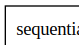

In [49]:
print(tf.keras.utils.model_to_dot(model, show_shapes=True, 
                                  show_layer_names=False, 
                                  rankdir="LR", 
                                  #subgraph=True,  
                                  expand_nested=True))
SVG(tf.keras.utils.model_to_dot(model, show_shapes=True, 
                                  show_layer_names=False, 
                                  rankdir="LR", 
                                  #subgraph=True,  
                                  expand_nested=True)
    .create(prog='dot',format='svg'))

In [41]:
print(model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir="LR", subgraph=True))

subgraph cluster_sequential {
label=sequential;
labeljust=l;
style=dashed;
2513198294856 [label="Conv2D\n|{input:|output:}|{{multiple}|{multiple}}"];
2513198295880 [label="MaxPooling2D\n|{input:|output:}|{{multiple}|{multiple}}"];
2513198296776 [label="Conv2D\n|{input:|output:}|{{multiple}|{multiple}}"];
2513198433992 [label="MaxPooling2D\n|{input:|output:}|{{multiple}|{multiple}}"];
2513198436232 [label="Flatten\n|{input:|output:}|{{multiple}|{multiple}}"];
2513198442632 [label="Dense\n|{input:|output:}|{{multiple}|{multiple}}"];
}



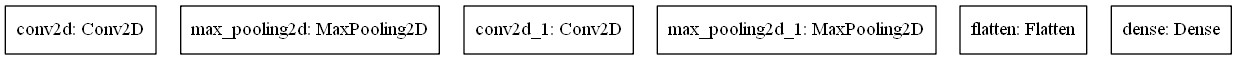

In [61]:
import keras
keras.utils.plot_model(model, rankdir="TB")

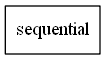

In [62]:
tf.keras.utils.plot_model(model, expand_nested=True, rankdir="LR")

# Toy Resnet
https://www.tensorflow.org/guide/keras/functional

In [64]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3), name='img')
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation='relu')(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name='toy_resnet')
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_3[0][0]                   
_________________________________________________________________________________________

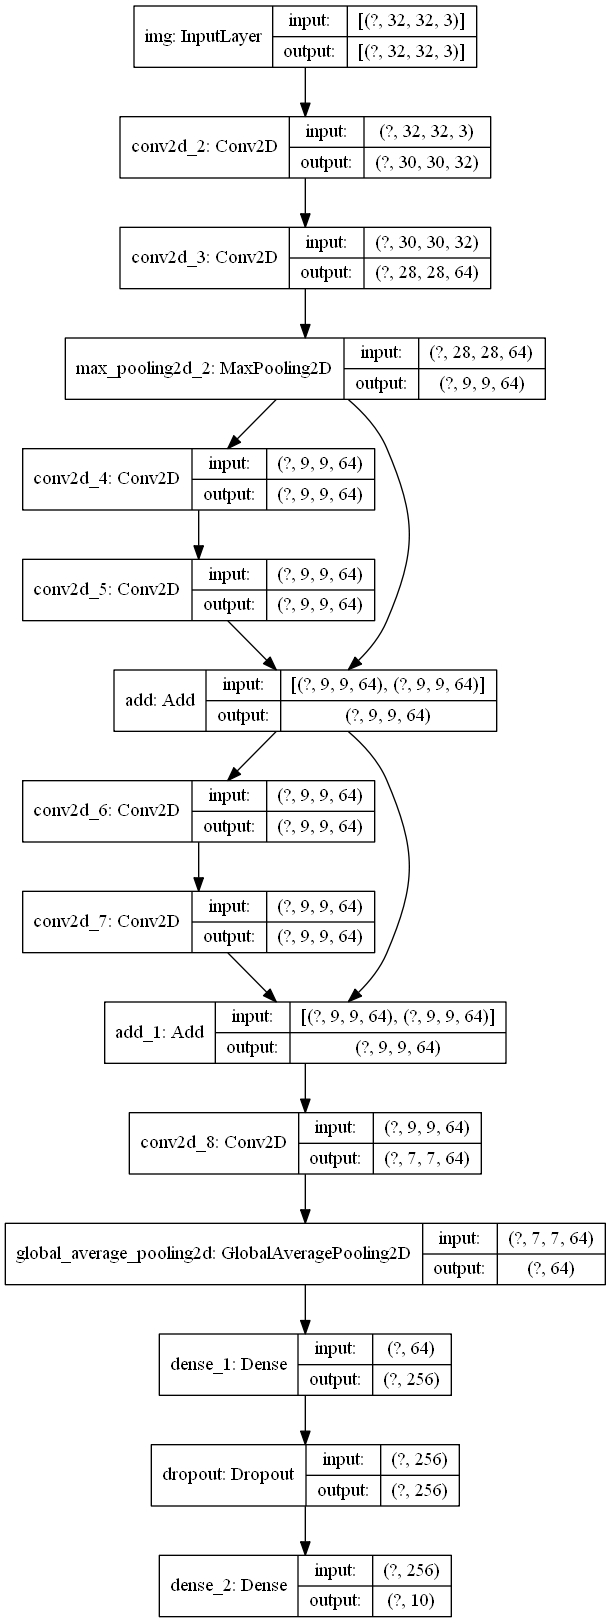

In [67]:
keras.utils.plot_model(model, show_shapes=True)

In [70]:
inputs = tf.keras.Input(shape=(64, 64, 3), name='img')
#W1 : [4, 4, 3, 8]
x=tf.keras.layers.Conv2D(filters=8, kernel_size=4, strides=(1,1),padding='same',activation='relu')(inputs)
x=tf.keras.layers.MaxPool2D(pool_size=(8, 8), strides=(8,8), padding='same')(x)
#W2 [2, 2, 8, 16]
x=tf.keras.layers.Conv2D(filters=16, kernel_size=2, strides=(1,1),padding='same',activation='relu')(x)
x=tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=(4,4), padding='same')(x)
x=tf.keras.layers.Flatten()(x)
outputs=tf.keras.layers.Dense(6)(x)
model = keras.Model(inputs, outputs, name='signs')
model.summary()

Model: "signs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 8)         392       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 16)          528       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390   

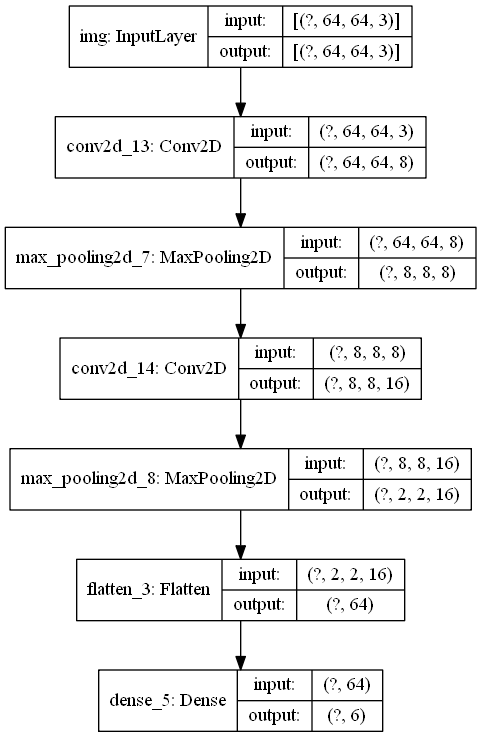

In [73]:
keras.utils.plot_model(model, show_shapes=True)